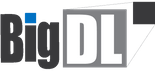

##### Copyright 2016 The BigDL Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install bigdl-chronos**

You can install the latest pre-release version with chronos support using `pip install --pre --upgrade bigdl-chronos[all]`.

In [2]:
# Install latest pre-release version of bigdl-chronos
# Installing bigdl-chronos from pypi
!pip install --pre --upgrade bigdl-chronos[pytorch]
!pip uninstall -y torchtext # uninstall torchtext to avoid version conflict
exit() # restart the runtime to refresh installed pkg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.4/352.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.5/585.5 kB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 kB 37.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 11.1 MB/s et

Found existing installation: torchtext 0.16.0
Uninstalling torchtext-0.16.0:
  Successfully uninstalled torchtext-0.16.0


### **Step 0: Download & prepare dataset**
We used NYC taxi passengers dataset in [Numenta Anomaly Benchmark (NAB)](https://github.com/numenta/NAB) for demo, which contains 10320 records, each indicating the total number of taxi passengers in NYC at a corresonponding time spot.

In [2]:
# load the dataset. The downloaded dataframe contains two columns, "timestamp" and "value".
import pandas as pd
url = "https://raw.githubusercontent.com/numenta/NAB/v1.0/data/realKnownCause/nyc_taxi.csv"
df = pd.read_csv(url, parse_dates=["timestamp"])

## **Time series forecasting using Chronos Forecaster**
### Forecaster Step1. Data transformation and feature engineering using Chronos TSDataset
[TSDataset](https://analytics-zoo.readthedocs.io/en/latest/doc/PythonAPI/Chronos/tsdataset.html) is our abstract of time series dataset for data transformation and feature engineering. Here we use it to preprocess the data.

In [3]:
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler

Initialize train, valid and test tsdataset from raw pandas dataframe.

In [4]:
tsdata_train, tsdata_valid, tsdata_test = TSDataset.from_pandas(df, dt_col="timestamp", target_col="value",
                                                                with_split=True, val_ratio=0.1, test_ratio=0.1)

Preprocess the datasets. Here we perform:
- deduplicate: remove those identical data records
- impute: fill the missing values
- gen_dt_feature: generate feature from datetime (e.g. month, day...)
- scale: scale each feature to standard distribution.
- roll: sample the data with sliding window.

For forecasting task, we will look back 3 hours' historical data (6 records) and predict the value of next 30 miniutes (1 records).

We perform the same transformation processes on train, valid and test set.

In [5]:
lookback, horizon = 48, 1

scaler = StandardScaler()
for tsdata in [tsdata_train, tsdata_valid, tsdata_test]:
    tsdata.deduplicate()\
          .impute()\
          .gen_dt_feature()\
          .scale(scaler, fit=(tsdata is tsdata_train))\
          .roll(lookback=lookback, horizon=horizon)

### Forecaster Step 2: Time series forecasting using Chronos Forecaster
After preprocessing the datasets. We can use [Chronos Forecaster](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Chronos/forecasters.html) to handle the forecasting tasks.

Transform TSDataset to sampled numpy ndarray and feed them to forecaster.

In [6]:
from bigdl.chronos.forecaster.tcn_forecaster import TCNForecaster

x, y = tsdata_train.to_numpy()
# x.shape = (num of sample, lookback, num of input feature)
# y.shape = (num of sample, horizon, num of output feature)

forecaster = TCNForecaster(past_seq_len=lookback,  # number of steps to look back
                           future_seq_len=horizon,  # number of steps to predict
                           input_feature_num=x.shape[-1],  # number of feature to use
                           output_feature_num=y.shape[-1],  # number of feature to predict
                           seed=1)
res = forecaster.fit((x, y), epochs=3)

INFO:pytorch_lightning.utilities.seed:Global seed set to 1
INFO:pytorch_lightning.utilities.seed:Global seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | NormalizeTSModel | 4.8 K 
1 | loss  | MSELoss          | 0     
-------------------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

### Forecaster Step 3: Further deployment with fitted forecaster
Use fitted forecaster to predict test data and plot the result

In [7]:
x_test, y_test = tsdata_test.to_numpy()
pred = forecaster.predict(x_test)
pred_unscale, groundtruth_unscale = tsdata_test.unscale_numpy(pred), tsdata_test.unscale_numpy(y_test)

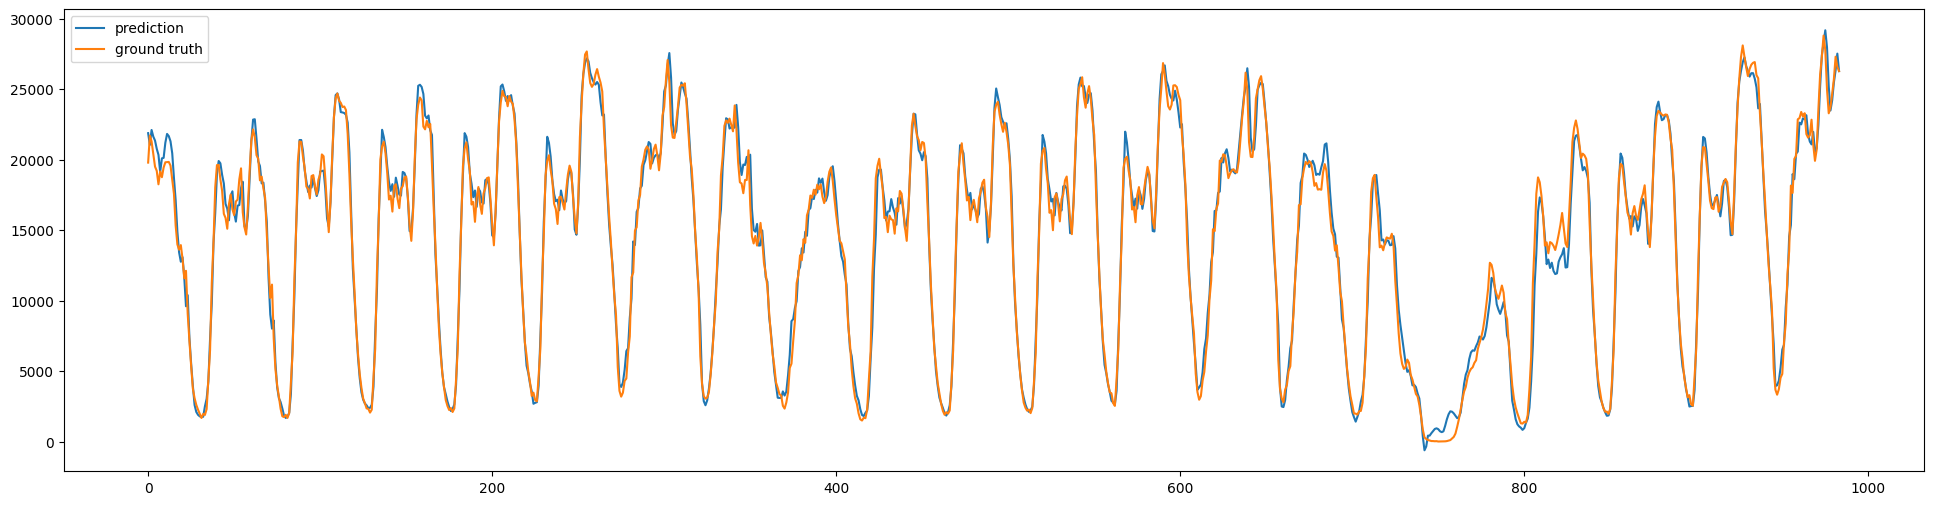

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24,6))
plt.plot(pred_unscale[:,:,0])
plt.plot(groundtruth_unscale[:,:,0])
plt.legend(["prediction", "ground truth"])

Save & restore the forecaster.

In [9]:
forecaster.save("nyc_taxi.fxt")
forecaster.load("nyc_taxi.fxt")

INFO:pytorch_lightning.utilities.seed:Global seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
